# Yoga Pose Detection Model

In [1]:
import cv2
import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# imported weights

In [3]:
net = cv2.dnn.readNetFromTensorflow("graph_opt.pb")#weights

In [4]:
inWidth=368
inHeight=368
thr=0.2

In [5]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [6]:
imgg=cv2.imread("./Train/downdog/00000133.jpg")
imgg.shape

(720, 1280, 3)

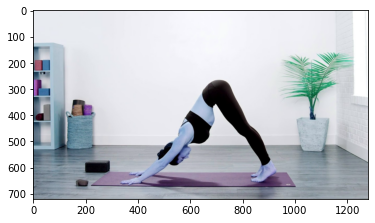

In [7]:
plt.imshow(imgg)

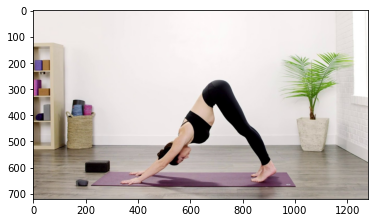

In [8]:
plt.imshow(cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB))

# function for pose estimation(imported the code from github)

In [9]:
def pose_estimation(imgs):
    imgsWidth=imgs.shape[1]
    imgsHeight=imgs.shape[0]
    net.setInput(cv2.dnn.blobFromImage(imgs,1.0,(inWidth,inHeight),(127.5,127.5,127.5),swapRB=True,crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (imgsWidth * point[0]) / out.shape[3]
        y = (imgsHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv2.line(imgs, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv2.ellipse(imgs, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(imgs, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv2.getTickFrequency() / 1000
    cv2.putText(imgs, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return imgs

# function to read all images from the image path in Train folder and detect poses for the same

In [10]:
def estimated_image(image_path):
    img = cv2.imread(image_path)
    img_s=img
    if img is not None:
        img_s=pose_estimation(img)
    return img_s

In [11]:
i=estimated_image("./Train/goddess/00000101.jpg")

# an example of a pose detection

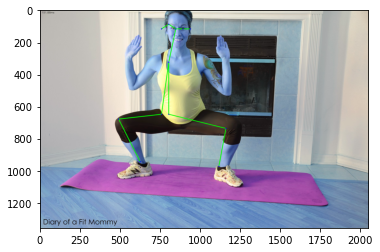

In [12]:
plt.imshow(i)

In [13]:
estimat_image=pose_estimation(imgg)

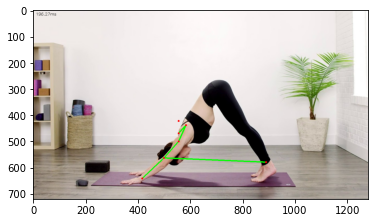

In [14]:
plt.imshow(cv2.cvtColor(estimat_image, cv2.COLOR_BGR2RGB))

In [71]:
path_to_data = "./Train/"
path_to_cr_data = "./Train/cropped/"

In [72]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

# here I created sub directories within the train folder of the points detected on each image

In [73]:
img_dirs

['./Train/cropped',
 './Train/downdog',
 './Train/goddess',
 './Train/plank',
 './Train/tree',
 './Train/warrior2']

In [74]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

# It ran through all images in the train folder and saved the pose detected image in the sub cropped folder

In [75]:
cropped_image_dirs = []
yoga_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    yoga_name = img_dir.split('/')[-1]
    yoga_file_names_dict[yoga_name] = []
    for entry in os.scandir(img_dir):
        img_s = estimated_image(entry.path)
        if img_s is not None:
            cropped_folder = path_to_cr_data + yoga_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = yoga_name + str(count) + ".jpg"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, img_s)
            yoga_file_names_dict[yoga_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./Train/cropped/downdog
Generating cropped images in folder:  ./Train/cropped/goddess
Generating cropped images in folder:  ./Train/cropped/plank
Generating cropped images in folder:  ./Train/cropped/tree
Generating cropped images in folder:  ./Train/cropped/warrior2


# Manually examine cropped folder and delete any unwanted images 

In [76]:
yoga_file_names_dict = {}
for img_dir in cropped_image_dirs:
    yoga_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    yoga_file_names_dict[yoga_name] = file_list
yoga_file_names_dict

{'downdog': ['./Train/cropped/downdog\\downdog1.jpg',
  './Train/cropped/downdog\\downdog10.jpg',
  './Train/cropped/downdog\\downdog100.jpg',
  './Train/cropped/downdog\\downdog101.jpg',
  './Train/cropped/downdog\\downdog102.jpg',
  './Train/cropped/downdog\\downdog103.jpg',
  './Train/cropped/downdog\\downdog104.jpg',
  './Train/cropped/downdog\\downdog105.jpg',
  './Train/cropped/downdog\\downdog106.jpg',
  './Train/cropped/downdog\\downdog107.jpg',
  './Train/cropped/downdog\\downdog108.jpg',
  './Train/cropped/downdog\\downdog109.jpg',
  './Train/cropped/downdog\\downdog11.jpg',
  './Train/cropped/downdog\\downdog110.jpg',
  './Train/cropped/downdog\\downdog111.jpg',
  './Train/cropped/downdog\\downdog112.jpg',
  './Train/cropped/downdog\\downdog113.jpg',
  './Train/cropped/downdog\\downdog114.jpg',
  './Train/cropped/downdog\\downdog115.jpg',
  './Train/cropped/downdog\\downdog116.jpg',
  './Train/cropped/downdog\\downdog117.jpg',
  './Train/cropped/downdog\\downdog118.jpg',
  '

# I labelled in numbers for each yoga pose name

In [77]:
class_dict = {}
count = 0
for yoga_name in yoga_file_names_dict.keys():
    class_dict[yoga_name] = count
    count = count + 1
class_dict

{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

# created x and y to be supplied to the model

In [78]:
X, y = [], []
for yoga_name, training_files in yoga_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1)))
        X.append(combined_img)
        y.append(class_dict[yoga_name])     

In [79]:
len(X[0])

3072

In [80]:
X[0]

array([[242],
       [240],
       [244],
       ...,
       [249],
       [249],
       [255]], dtype=uint8)

In [81]:
y[0]

0

In [83]:
X = np.array(X).reshape(len(X),3072).astype(float)
X.shape

(1006, 3072)

In [84]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# created training and testing sample within train folder and supply it to the svm model.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.746031746031746

In [86]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75        42
           1       0.72      0.57      0.63        46
           2       0.78      0.81      0.80        58
           3       0.83      0.68      0.75        37
           4       0.78      0.75      0.76        69

    accuracy                           0.75       252
   macro avg       0.75      0.74      0.74       252
weighted avg       0.75      0.75      0.74       252



In [87]:
y_predicted=pipe.predict(X_test)

# Here I achieved 75% accuracy with the training sample using svm.

In [88]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75        42
           1       0.72      0.57      0.63        46
           2       0.78      0.81      0.80        58
           3       0.83      0.68      0.75        37
           4       0.78      0.75      0.76        69

    accuracy                           0.75       252
   macro avg       0.75      0.74      0.74       252
weighted avg       0.75      0.75      0.74       252



# save the model using joblib and pickle

In [90]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(pipe, 'saved_model3.pkl')

['saved_model3.pkl']

In [91]:
Pkl_Filename = "Pickle_pipe_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(pipe, file)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

# load the model again for testing in test folder

In [92]:
joblib_pipe_model = joblib.load("saved_model3.pkl")


joblib_pipe_model

In [93]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_pipe_Model = pickle.load(file)

Pickled_pipe_Model

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

In [33]:
y_predicted[:5]

array([3, 3, 3, 1, 0])

In [34]:
y_test[:5]

[3, 3, 1, 1, 2]

In [35]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [36]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

# Also before testing it into test folder I check whether any other model will perform better than svm. But I got the highest accuracy with the svm model and so I proceed it with it.

In [37]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.640442,"{'svc__C': 100, 'svc__kernel': 'rbf'}"
1,random_forest,0.531709,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.611320,{'logisticregression__C': 5}


In [38]:
best_estimators['svm'].score(X_test,y_test)

0.7420634920634921

In [39]:
best_estimators['random_forest'].score(X_test,y_test)

0.5634920634920635

In [40]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.6190476190476191

In [41]:
best_clf = best_estimators['svm']

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[38,  2,  1,  0,  1],
       [ 3, 26,  8,  2,  7],
       [10,  1, 46,  0,  1],
       [ 2,  4,  0, 25,  6],
       [ 7,  3,  4,  3, 52]], dtype=int64)

Text(69.0, 0.5, 'Truth')

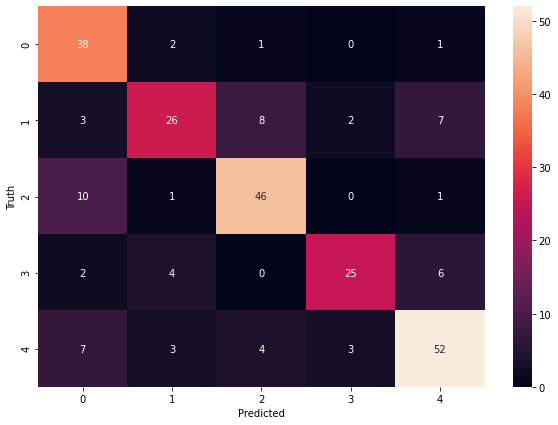

In [43]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [44]:
class_dict

{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

# I repeat the steps for the test folder to create x and y samples to supply it into the loaded model

In [46]:
path_to_data = "./Test/"
path_to_cr_data = "./Test/cropped/"

In [48]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [49]:
img_dirs

['./Test/downdog',
 './Test/goddess',
 './Test/plank',
 './Test/tree',
 './Test/warrior2']

In [50]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

# pose points detected in test folder

In [51]:
cropped_image_dirs = []
yoga_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    yoga_name = img_dir.split('/')[-1]
    yoga_file_names_dict[yoga_name] = []
    for entry in os.scandir(img_dir):
        img_s = estimated_image(entry.path)
        if img_s is not None:
            cropped_folder = path_to_cr_data + yoga_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = yoga_name + str(count) + ".jpg"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, img_s)
            yoga_file_names_dict[yoga_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./Test/cropped/downdog
Generating cropped images in folder:  ./Test/cropped/goddess
Generating cropped images in folder:  ./Test/cropped/plank
Generating cropped images in folder:  ./Test/cropped/tree
Generating cropped images in folder:  ./Test/cropped/warrior2


In [52]:
yoga_file_names_dict = {}
for img_dir in cropped_image_dirs:
    yoga_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    yoga_file_names_dict[yoga_name] = file_list
yoga_file_names_dict

{'downdog': ['./Test/cropped/downdog\\downdog1.jpg',
  './Test/cropped/downdog\\downdog10.jpg',
  './Test/cropped/downdog\\downdog11.jpg',
  './Test/cropped/downdog\\downdog12.jpg',
  './Test/cropped/downdog\\downdog13.jpg',
  './Test/cropped/downdog\\downdog14.jpg',
  './Test/cropped/downdog\\downdog15.jpg',
  './Test/cropped/downdog\\downdog16.jpg',
  './Test/cropped/downdog\\downdog17.jpg',
  './Test/cropped/downdog\\downdog18.jpg',
  './Test/cropped/downdog\\downdog19.jpg',
  './Test/cropped/downdog\\downdog2.jpg',
  './Test/cropped/downdog\\downdog20.jpg',
  './Test/cropped/downdog\\downdog21.jpg',
  './Test/cropped/downdog\\downdog22.jpg',
  './Test/cropped/downdog\\downdog23.jpg',
  './Test/cropped/downdog\\downdog24.jpg',
  './Test/cropped/downdog\\downdog25.jpg',
  './Test/cropped/downdog\\downdog26.jpg',
  './Test/cropped/downdog\\downdog27.jpg',
  './Test/cropped/downdog\\downdog28.jpg',
  './Test/cropped/downdog\\downdog29.jpg',
  './Test/cropped/downdog\\downdog3.jpg',
  '

In [53]:
class_dict = {}
count = 0
for yoga_name in yoga_file_names_dict.keys():
    class_dict[yoga_name] = count
    count = count + 1
class_dict

{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

# Test samples created for the test folder as X1 and y1

In [57]:
X1, y1 = [], []
for yoga_name, training_files in yoga_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1)))
        X1.append(combined_img)
        y1.append(class_dict[yoga_name])

In [58]:
len(X1[0])

3072

In [59]:
X1 = np.array(X1).reshape(len(X1),3072).astype(float)
X1.shape

(470, 3072)

# Supply X1 and y1 to the loaded model using both pickle and joblib

In [94]:
score = Pickled_pipe_Model.score(X1, y1)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  

# Predict the Labels using the reloaded Model
Ypredict = Pickled_pipe_Model.predict(X1)  

Ypredict

Test score: 70.00 %


array([0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 4, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 4, 0, 0, 4, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 1, 4, 4, 4, 1, 1, 1, 1, 4, 0,
       1, 4, 1, 2, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 2, 4, 1, 2, 1, 4, 4, 4,
       0, 0, 4, 4, 1, 4, 1, 4, 0, 4, 1, 1, 4, 0, 1, 1, 1, 1, 0, 4, 4, 2,
       1, 1, 1, 2, 1, 2, 4, 1, 4, 4, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 2, 4,
       1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4,
       2, 0, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 4,
       2, 0, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 0, 0, 4,
       2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 0, 3, 3, 4, 4, 3, 3, 3, 3,

In [95]:
score = joblib_pipe_model.score(X1, y1)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  

# Predict the Labels using the reloaded Model
Y_predict = joblib_pipe_model.predict(X1)  

Y_predict

Test score: 70.00 %


array([0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 4, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 4, 0, 0, 4, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 1, 4, 4, 4, 1, 1, 1, 1, 4, 0,
       1, 4, 1, 2, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 2, 4, 1, 2, 1, 4, 4, 4,
       0, 0, 4, 4, 1, 4, 1, 4, 0, 4, 1, 1, 4, 0, 1, 1, 1, 1, 0, 4, 4, 2,
       1, 1, 1, 2, 1, 2, 4, 1, 4, 4, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 2, 4,
       1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4,
       2, 0, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 4,
       2, 0, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 0, 0, 4,
       2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 0, 3, 3, 4, 4, 3, 3, 3, 3,

# I check for some samples where I found it is showing error for some values while working fine for most cases

In [100]:
Ypredict[10:20]

array([0, 2, 0, 2, 0, 0, 0, 0, 0, 0])

In [101]:
y1[10:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# I achieved 70% accuracy with the test folder and works fine for the majority of the test cases

In [102]:
print(classification_report(y1,Ypredict))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73        97
           1       0.63      0.46      0.53        80
           2       0.75      0.83      0.79       115
           3       0.91      0.75      0.83        69
           4       0.58      0.63      0.61       109

    accuracy                           0.70       470
   macro avg       0.71      0.69      0.70       470
weighted avg       0.70      0.70      0.70       470

